In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import folium
from folium import Choropleth

In [2]:
# State shapefile source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2014.html

# set the filepath and load in the shapefile of US states
statesFile = "zip://cb_2014_us_state_20m.zip"
states_df = gpd.read_file(statesFile)


states_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


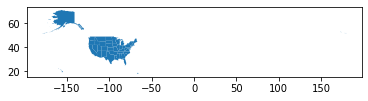

In [3]:
states_df.plot()

In [4]:
# Open up the pollution data file
pollution_df = pd.read_csv("./Facility Air Pollution Dataset - All Facilities.csv")

C:\Users\Brian\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
pollution_df.head()

,Unique ID,FacilityName,Rank_TRI_14,Rank_GHG_14,Latitude,Longitude,LocationAddress,City,State,ZIP,...,Sixth_GHG_ID,TRI_ID,Second_TRI_ID,Third_TRI_ID,Fourth_TRI_ID,Fifth_TRI_ID,FRS_ID,Second_FRS_ID,Third_FRS_ID,Fourth_FRS_ID
0,110002003153,TRIDENT SEAFOODS CORP AKUTAN SHORE PLANT,5513.0,3888.0,54.132189,-165.786894,1 SALMON LN,AKUTAN,AK,99553,...,NaN,99553TRDNTAKUTA,NaN,NaN,NaN,NaN,110002003153,NaN,NaN,NaN
1,110064064408,UNISEA INC SEAFOOD,NaN,5470.0,53.878858,-166.553496,88 SALMON WAY,DUTCH HARBOR,AK,996920008,...,NaN,99692NSNC POUCH,NaN,NaN,NaN,NaN,110064064408,NaN,NaN,NaN
2,110064048926,DUTCH HARBOR POWER PLANT,NaN,5208.0,53.892130,-166.533010,1732 EAST POINT RD,DUTCH HARBOR,AK,99692,...,NaN,NaN,NaN,NaN,NaN,NaN,110064048926,NaN,NaN,NaN
3,110000491735,FLINT HILLS RESOURCES ALASKA LLC ANCHORAGE TER...,3511.0,NaN,61.230110,-149.890900,1076 OCEAN DOCK RD,ANCHORAGE,AK,99501,...,NaN,99501MPCLS1076O,NaN,NaN,NaN,NaN,110000491735,NaN,NaN,NaN
4,110000498131,TESORO LOGISTICS GP LLC-ANCHOR AGE TERMINAL,5886.0,NaN,60.808079,-148.940007,1522 PORT RD,ANCHORAGE,AK,99501,...,NaN,99501TSRLS1522P,NaN,NaN,NaN,NaN,110000498131,NaN,NaN,NaN


In [6]:
# Remove values marked "Not reported" because they don't contribute to the sum

# Pandas has its own vectorized string operators, useful for operations on entire data columns or rows.
# ~ is a bitwise not operator.
# In this case it's being used to find any rows which don't contain the String "Not reported".
pollution_df = pollution_df[~pollution_df.GHG_Direct_Emissions_14_in_metric_tons.str.contains("Not reported")]

# Clean up the 2014 GHG emissions column by converting the values to integers
pollution_df['GHG_Direct_Emissions_14_in_metric_tons'] = pd.to_numeric(pollution_df['GHG_Direct_Emissions_14_in_metric_tons'])

Make a Choropleth map based on the total greenhouse gas emissions for each state.

In [7]:
# Start by making a pivot table to sum the total emissions by state
pollution_pivot = pd.pivot_table(
    data=pollution_df,
    values='GHG_Direct_Emissions_14_in_metric_tons',
    index=['State'],
    aggfunc=np.sum)

In [8]:
# Check out which states had the most GHG emissions in 2014
pollution_pivot.sort_values(by='GHG_Direct_Emissions_14_in_metric_tons', ascending=False).head()

,GHG_Direct_Emissions_14_in_metric_tons
State,
TX,408071503
IN,159617422
OH,137737337
LA,137704495
PA,136820895


In [9]:
# join the GEOdataframe with the cleaned up GHG data
US_emissions_geo = states_df.set_index('STUSPS').join(pollution_pivot)

US_emissions_geo.sort_values(by='GHG_Direct_Emissions_14_in_metric_tons', ascending=False).head()

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GHG_Direct_Emissions_14_in_metric_tons
STUSPS,,,,,,,,,,
TX,48,01779801,0400000US48,48,Texas,00,676601887070,19059877230,"POLYGON Z ((-106.62345 31.91403 0.00000, -106....",408071503
IN,18,00448508,0400000US18,18,Indiana,00,92790411854,1535839439,"POLYGON Z ((-88.05947 37.86669 0.00000, -88.04...",159617422
OH,39,01085497,0400000US39,39,Ohio,00,105831263791,10266413579,"MULTIPOLYGON Z (((-82.86334 41.69369 0.00000, ...",137737337
LA,22,01629543,0400000US22,22,Louisiana,00,111901043977,23750204105,"POLYGON Z ((-94.04305 32.69303 0.00000, -94.04...",137704495
PA,42,01779798,0400000US42,42,Pennsylvania,00,115884023072,3396010541,"POLYGON Z ((-80.51989 40.90666 0.00000, -80.51...",136820895


In [10]:

m_1 = folium.Map(location=[39.012, -98.484], tiles='cartodbpositron', zoom_start=4)


# Create a choropleth map of the GHG emissions
emissions_choropleth = folium.Choropleth(
    geo_data=US_emissions_geo.__geo_interface__,
    data=US_emissions_geo['GHG_Direct_Emissions_14_in_metric_tons'],
    key_on='feature.id',
    fill_color='YlGnBu',
    nan_fill_opacity=0,
    legend_name='Greenhouse Gas Direct Emissions in 2014 (metric tons)',
    name='Chorpleth Layer'
)

# Add tooltips for each area showing the name of each state and the amount of GHGs emitted 
emissions_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['NAME', 'GHG_Direct_Emissions_14_in_metric_tons'])
)

emissions_choropleth.add_to(m_1)

In [11]:
m_1

Make a bubble map that shows information on specific air monitoring facilities. Which ones detected abnormally large amounts of pollution? Start by investigating Texas.

In [12]:
# The Dataframe.groupby method creates a table of data with each unique combination of values in multiple columns,
# for latitude and longitude values here.
# The state column can also be added harmlessly without creating any extra rows.

# Use the groupby.sum method to find the total GHG emissions for each facility
stations_df = pollution_df.groupby(['Latitude', 'Longitude', 'State'])['GHG_Direct_Emissions_14_in_metric_tons'].sum()

# convert the groupby method's output to a more legible dataframe
stations_df = stations_df.reset_index()
stations_df = stations_df.rename(columns={
    "GHG_Direct_Emissions_14_in_metric_tons": "Total_GHG_Emissions_in_2014"
})
stations_df.sort_values(by='Total_GHG_Emissions_in_2014', ascending=False).head()

,Latitude,Longitude,State,Total_GHG_Emissions_in_2014
1593,33.061300,-83.806600,GA,20482460
1832,33.633100,-87.059700,AL,19902660
3081,36.903333,-111.390278,AZ,17248449
3636,38.371789,-87.767666,IN,16294739
343,29.478295,-95.635775,TX,16130246


In [13]:
# Use the state column to separate out facilities in Texas for mapping
texas_stations_df = stations_df.loc[stations_df['State'] == 'TX']
texas_stations_df.sort_values(by='Total_GHG_Emissions_in_2014', ascending=False).head()

,Latitude,Longitude,State,Total_GHG_Emissions_in_2014
343,29.478295,-95.635775,TX,16130246
310,29.308764,-98.321969,TX,15360936
1194,32.259653,-94.570331,TX,14844879
900,31.110600,-96.290700,TX,12888185
960,31.413972,-96.250028,TX,11607933


In [14]:
# Find the mean and standard deviation of the total GHG emissions in Texas to distinguish the different facilities
# depending on how close their emissions were to the mean.
texas_GHG_mean = texas_stations_df['Total_GHG_Emissions_in_2014'].mean()
texas_GHG_stdev = texas_stations_df['Total_GHG_Emissions_in_2014'].std()

print("Mean: %d\nStandard Deviation: %d" % (texas_GHG_mean, texas_GHG_stdev))

Mean: 489263
Standard Deviation: 1515932


In [15]:
# Create the bubble map for air pollution facilities in Texas

m_2 = folium.Map(location=[32.015, -99.153], tiles='cartodbpositron', zoom_start=5)

# Assign each facility a different color based on how many standard deviations its emissions are from the mean 
def color_picker(emissions):
    if emissions <= texas_GHG_mean:
        return "lightblue"
    elif emissions <= (texas_GHG_mean + texas_GHG_stdev):
        return "green"
    elif emissions <= (texas_GHG_mean + texas_GHG_stdev * 2):
        return "yellow"      # 95% of data points should fall within 2 standard deviations of the mean
    elif emissions <= (texas_GHG_mean + texas_GHG_stdev * 3):
        return "orange"
    else:
        return "crimson"     # Only the most serious outliers should be > 3 standard deviations away

# Draw a circle for each station
for i in range(0,len(texas_stations_df.index)):
    folium.Circle(
        location=[texas_stations_df.iloc[i]['Latitude'], texas_stations_df.iloc[i]['Longitude']],
        radius=20,
        color=color_picker(texas_stations_df.iloc[i]['Total_GHG_Emissions_in_2014'])).add_to(m_2)

In [16]:
m_2

Some clusters of air monitoring stations with specific colors formed on the map.

Light Blue, with emissions less than or equal to the mean:
Many of these stations are far from the densely populated coastal cities.

Green, with emissions within 1 standard deviation above the mean:
Several green clusters formed near major cities. The area between Austin and San Antonio has at least 10 stations that fall into this range.

Yellow, with emissions within 1 standard deviation above the mean:
All of the yellow stations are close to the coast or not far from Dallas.

Stations colored Orange or Crimson are rare and don't follow an obvious trend.